# Introduction

Key takeaways
* Installing packages
* Handling data with pandas
* Unzipping Files with Python
* Using seaborn for vizualization
* Using matplotlib for vizualization
* Creating Lambda functions
* Deploying machine learning models
* Evaluating machine learning results
* Validating aggregates

# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What is the mission of Airbnb?
        b. What is more likely to cause bad reviews?
        c. What is the cost of bad reviews?
        d. What is the value of good reviews?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

# Data Handling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os

In [2]:
def unzip_files(zip_filename_list, folder=None):
    """
    Unzipping the datasets
    """
    folder_names = []
    for file in zip_filename_list:
        
        # paths
        filename_path = os.path.join('data', file)
        folder_name = filename_path[:-4].replace("-", "_")
        
        # extracting
        try:
            zip_ref = ZipFile(filename_path)
            zip_ref.extractall(folder_name)
            zip_ref.close()
        except:
            print('File already extracted!')
        
        # appending folder names
        if filename_path.find('.') >= 0:
            folder_names.append(folder_name)
        
    return folder_names

In [3]:
def read_concat(folder_names, target_file_name):
    """
    Reading files of different folders with same naming convention
    """
    df_con = pd.DataFrame()
    for folder in folder_names:
        target = os.path.join(folder, target_file_name)
        df = pd.read_csv(target)
        df['rowsource'] = target
        
        df_con = pd.concat([df_con, df], axis=0, sort=True)
    return df_con

## - Extracting Data

In [4]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip', 'seattle.zip']

In [5]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

['data\\boston_airbnb_open_data', 'data\\seattle']

In [6]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

## - Importing Data

---
First, we are importing the calendar dataset.

In [7]:
calendar = read_concat(folder_names, 'calendar.csv')

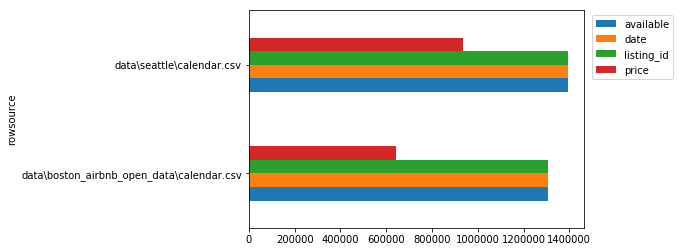

In [8]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

---
Second, we are importing the listings dataset.

In [9]:
listings = read_concat(folder_names, 'listings.csv')

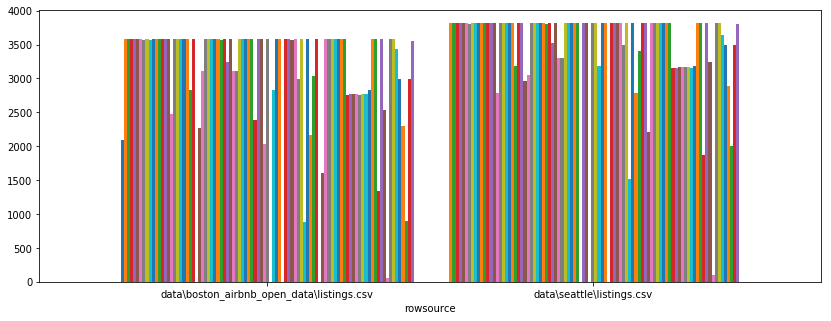

In [10]:
listings\
    .groupby('rowsource')\
    .count()\
    .plot.bar(legend=False, figsize=(14, 5), rot=0, width=.9);

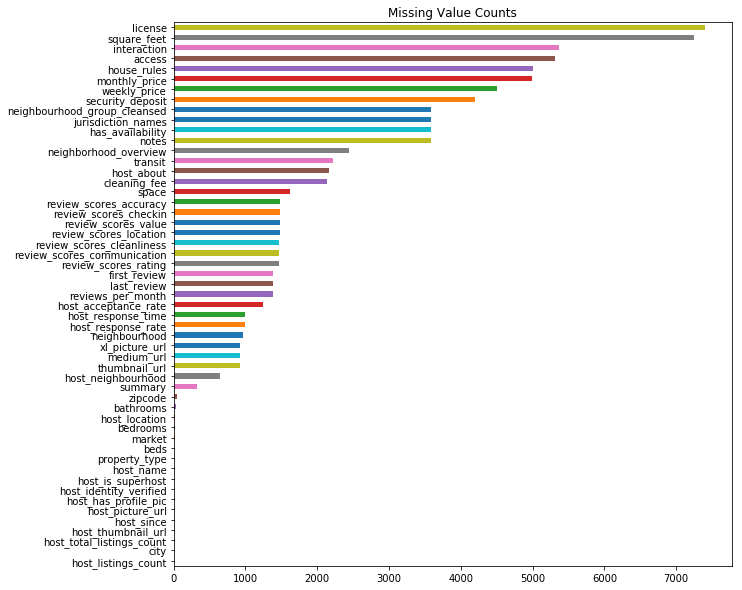

In [11]:
listings.isnull().sum()\
    .where(lambda x: x>0)\
    .dropna()\
    .sort_values(ascending=True)\
    .plot.barh(figsize=(10, 10), title="Missing Value Counts");

In [12]:
listings.shape

(7403, 96)

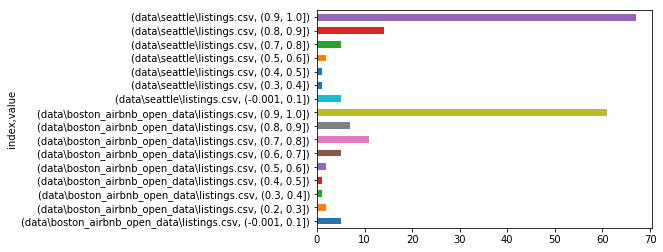

In [13]:
non_complete_listings = listings.groupby('rowsource')\
    .count()\
    .div(listings.rowsource.value_counts(), axis=0)\
    .reset_index()\
    .melt(id_vars='index')

non_complete_listings\
    .groupby(['index', pd.cut(non_complete_listings.value, bins=10)])\
    .size()\
    .plot.barh();

---
Third, we are importing the reviews dataset.

In [14]:
reviews = read_concat(folder_names, 'reviews.csv')

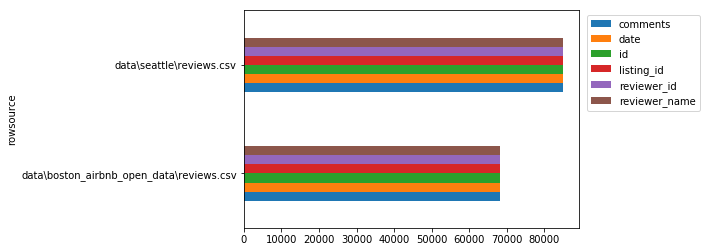

In [15]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');

**Data Import Findings:**
* It is clear that calendar has missing prices.
* It is clear that there are multiple columns with missing values on both datasets.
* On the contrary, reviews are all complete.

## Data Understanding

### <li> Calendar

In [16]:
# calendar first 5 lines
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


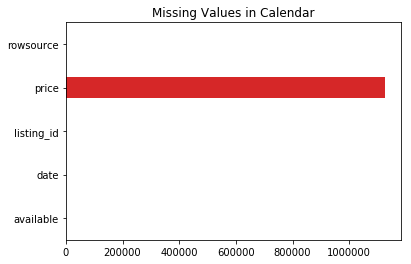

In [17]:
calendar.isnull().sum().plot.barh(title="Missing Values in Calendar");

#### Available Feature

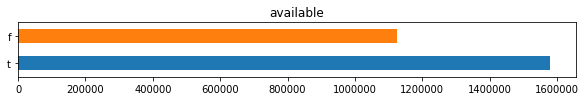

In [18]:
calendar.available.value_counts().plot.barh(figsize=(10, 1), title='available');

#### Price Feature

In [19]:
calendar.price.unique()

array([nan, '$65.00', '$75.00', ..., '$10.00', '$24.00', '$817.00'],
      dtype=object)

In [20]:
# Data conversions
calendar.price = calendar.price.str.replace('$', '')
calendar.price = calendar.price.str.replace(',', '').astype(float)
calendar.date = pd.to_datetime(calendar.date)

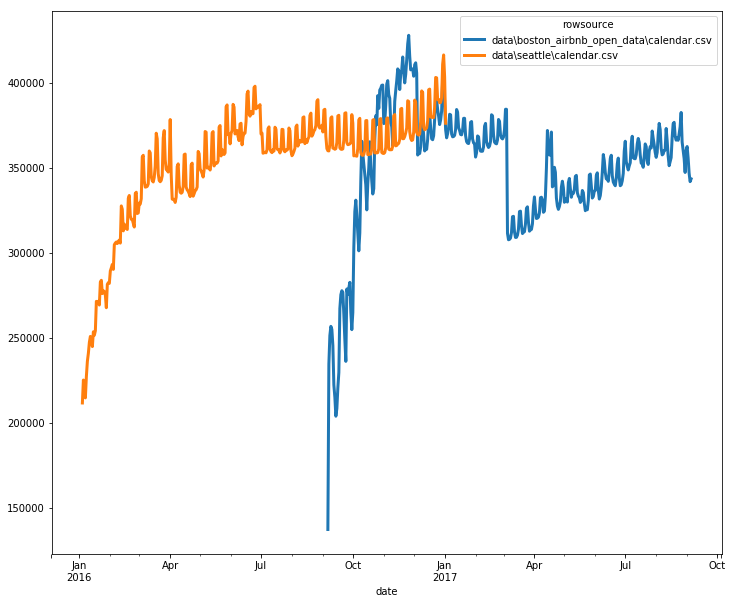

In [21]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

In [22]:
calendar['nan_grp'] = calendar.price.fillna('MissingValue')

In [23]:
calendar.loc[calendar.nan_grp!='MissingValue', 'nan_grp'] = 'ProvidedValue'

In [24]:
calendar['source_grp'] = calendar.rowsource.str.cat(calendar.nan_grp, sep=' - ')

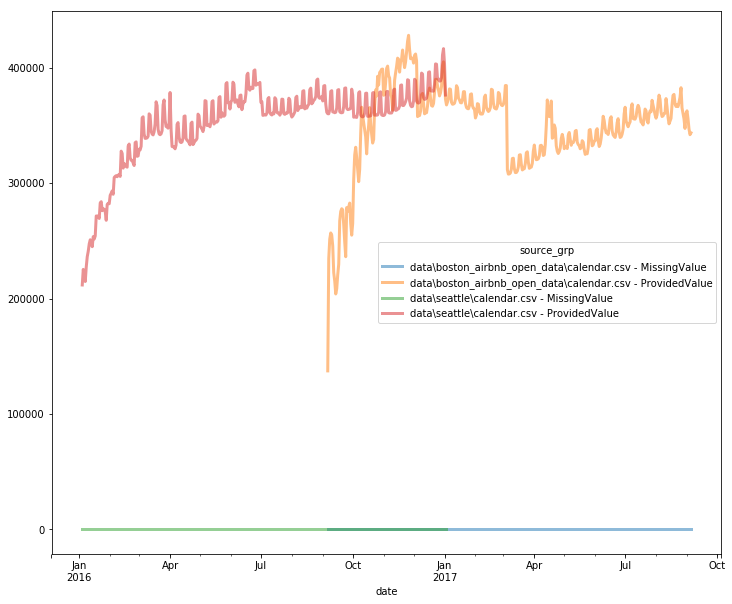

In [25]:
calendar.groupby(['source_grp', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='source_grp', values='price')\
    .plot.line(figsize=(12, 10), lw=3, alpha=.5);

In [26]:
calendar.groupby('source_grp').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_grp                                                              
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

In [27]:
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(month_func)- x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1)- x.max_date

calendar.groupby('rowsource').agg({'date': 'max'})\
    .rename(columns={'date':'max_date'})\
    .assign(delta_month=delta_month_func,
            delta_days=delta_days_func)\
    .fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


**Calendar Data Findings:**

Informational:
* Records of availability and price at a date and listing id level.
* Only missing values are in prices. Some listings have no prices.
* Dates of datasets do not match.
    * It seems that seattle was service before boston.
    * Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days.
Transformation:
* Prices have to be cleaned. They include $ sign and comma separators.

### <li> Listings

In [28]:
missing_pct = listings.isnull().sum()/listings.shape[0]

#### Object Features

In [29]:
# listings first 5 lines
pd.options.display.max_rows = 100
listings.select_dtypes(include=object).dropna(axis=0, how='all').sample(2).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [2,0,1]].sort_values('missing', ascending=False).style.bar()

,missing,2814,1720
interaction,0.725652,nan,nan
access,0.716872,nan,nan
house_rules,0.676753,nan,nan
monthly_price,0.675132,"$2,200.00",nan
weekly_price,0.608132,$800.00,nan
security_deposit,0.566662,$100.00,$300.00
jurisdiction_names,0.484263,WASHINGTON,WASHINGTON
neighbourhood_group_cleansed,0.484263,Capitol Hill,West Seattle
has_availability,0.484263,t,t
notes,0.483723,nan,nan


#### Non-Object Features

In [31]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T\
    .merge(missing_pct.to_frame('missing'), left_index=True, right_index=True, how='left')\
    .iloc[:, [-1, 0, 1, 2, 3]]\
    .sort_values('missing', ascending=False)\
    .style.format("{:2,.2f}").bar(subset=['missing'])

,missing,2032,3688,517,1
license,1.00,nan,nan,nan,nan
square_feet,0.98,nan,nan,nan,nan
review_scores_accuracy,0.20,nan,9.00,10.00,10.00
review_scores_checkin,0.20,nan,10.00,9.00,10.00
review_scores_value,0.20,nan,9.00,10.00,9.00
review_scores_location,0.20,nan,10.00,9.00,9.00
review_scores_cleanliness,0.20,nan,9.00,9.00,9.00
review_scores_communication,0.20,nan,10.00,10.00,10.00
review_scores_rating,0.20,nan,94.00,96.00,94.00
reviews_per_month,0.19,nan,2.39,3.00,1.30


### <li> Reviews

In [32]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


### <li> Id Relationships

In [47]:
len_func = lambda x: x.str.len()

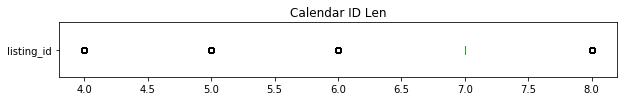

In [53]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

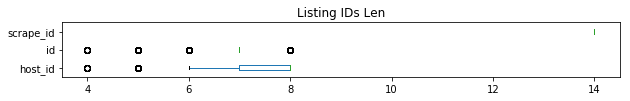

In [54]:
listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

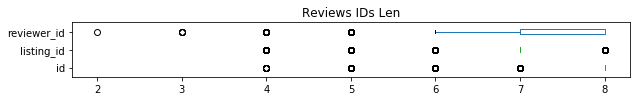

In [55]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

**ID Findings**
* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so therefore si irrelevant for the analysis.
* The host_id in the listing dataset seems to be related to the reviewer_d of the reviews dataset.
* Given that there are reviewer-ids with length of 2 and 3 in the reviwers dataset and not in the listings dataset, we can assume that the listings don't inlcude stays (missing records) for those host with 2 and 3 lenght-ids, but those host have reviews for the listings in the reviewer dataset.

### <li> Granularity of Datasets

#### Calendar Granularity

In [93]:
duplicates = calendar.groupby(['date', 'listing_id', 'rowsource', 'available'])\
    .size().to_frame('duplicates').query("duplicates>1").head()

##### <ol> Examples of Calendar Duplicates

In [104]:
calendar_price_dups = duplicates.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {listing_dups}")

These are the id of price duplicates: 
 12898806


In [101]:
filter_cond = (calendar.listing_id == 12898806)
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,nan_grp,source_grp
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


### Listing Granularity

In [109]:
listings.groupby(['id']).size().max()

1

In [128]:
listings.select_dtypes(exclude=np.datetime_as_string)

TypeError: data type not understood

### <li> Testing Relationships

#### Prices for Listings

In [ ]:
listings

In [1]:
os.system("git add .")

NameError: name 'os' is not defined

In [307]:
os.system('git commit -m "Understading Listing Data"')

0

In [308]:
os.system("git push")

0

## Preparing Data for Analysis

# Analysis & Visualizations

# Modeling & Visualizations

# Evaluating Results

# Conclussion